In [ ]:
!wget https://data.lhncbc.nlm.nih.gov/public/Malaria/cell_images.zip

--2022-03-08 03:35:46--  https://data.lhncbc.nlm.nih.gov/public/Malaria/cell_images.zip
Resolving data.lhncbc.nlm.nih.gov (data.lhncbc.nlm.nih.gov)... 52.84.159.46, 52.84.159.7, 52.84.159.119, ...
Connecting to data.lhncbc.nlm.nih.gov (data.lhncbc.nlm.nih.gov)|52.84.159.46|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 353452851 (337M) [application/zip]
Saving to: ‘cell_images.zip’

cell_images.zip     100%[===================>] 337.08M  41.0MB/s    in 8.9s    

2022-03-08 03:35:56 (37.7 MB/s) - ‘cell_images.zip’ saved [353452851/353452851]



In [ ]:
!unzip /content/cell_images.zip

In [ ]:
pip install split-folders

In [ ]:
import splitfolders
splitfolders.ratio('/content/cell_images', output="output", seed=1337, ratio=(.8, 0.2)) 

Copying files: 27560 files [00:06, 4258.67 files/s]


In [96]:
train_dir = '/content/output/train/'
validation_dir = '/content/output/val/'

In [ ]:
import numpy as np
import pandas
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, concatenate, Conv2D, MaxPooling2D, Input, Dropout, BatchNormalization
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler, LabelEncoder 
from numpy import asarray
import cv2
import os
from matplotlib import pyplot as plt

In [ ]:
!ls

cell_images  cell_images.zip  sample_data


In [ ]:
parasitized_images = len(os.listdir(train_dir+'Parasitized/'))
uninfected_images = len(os.listdir(train_dir+'Uninfected'))
parasitized_images_val = len(os.listdir(validation_dir+'Parasitized/')) 
uninfected_images_val = len(os.listdir(validation_dir+'Uninfected/')) 
total_train = parasitized_images + uninfected_images  
total_val = parasitized_images_val + uninfected_images_val 

In [ ]:
data = []
label = []

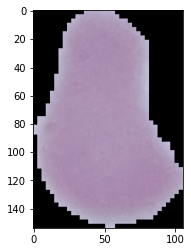

In [ ]:
uninfected = os.listdir('/content/cell_images/Uninfected/')
for i,name in enumerate(uninfected):
  if(name.split('.')[1]=='png'):
     image_array= cv2.imread('/content/cell_images/Uninfected/'+name) #Image is in gray scale to lessen load on model
     plt.imshow(image_array)
     plt.show()
     break  


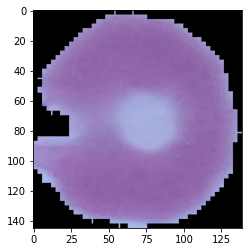

In [ ]:
infected = os.listdir('/content/cell_images/Parasitized/')
for i,name in enumerate(infected):
  if(name.split('.')[1]=='png'):
     image_array= cv2.imread('/content/cell_images/Parasitized/'+name) #Image is in gray scale to lessen load on model
     plt.imshow(image_array)
     plt.show()
     break  


In [ ]:
# Displaying the label class and its respective key value for the class 
labelClass = list(train_data_gen.class_indices.items())

# Showing the values 
print("Label Class: {}".format(labelClass))


Label Class: [('Parasitized', 0), ('Uninfected', 1)]


In [ ]:
batch_size = 2000
epochs = 20 
IMG_HEIGHT = 64
IMG_WIDTH = 64 

In [ ]:
# Creating the generator for our training images data and for our validation images data 
train_image_gen = ImageDataGenerator(rescale = 1.0 / 255.0)
validation_image_gen = ImageDataGenerator(rescale = 1.0 / 255.0) 

# Getting the training images from the train directory by using the flow from directory method 
# to load the images with a stated batch size and an image height and width. 
train_data_gen = train_image_gen.flow_from_directory(batch_size = batch_size, 
                                                    directory = train_dir, 
                                                    shuffle = True, 
                                                    target_size = (IMG_HEIGHT, IMG_WIDTH), 
                                                    class_mode = "binary")

# Getting the validation images from the validation directory by using the flow from_from_directory method 
# to load the images, shuffle them, and resize them with an image height and a specified width value. 
validation_data_gen =validation_image_gen.flow_from_directory(batch_size = batch_size, 
                                                             directory = validation_dir, 
                                                             shuffle = True, 
                                                             target_size = (IMG_HEIGHT, IMG_WIDTH), 
                                                             class_mode = "binary")

Found 22046 images belonging to 2 classes.
Found 5512 images belonging to 2 classes.


In [ ]:
def cnn():
  inputs = Input((64, 64, 3))
  inp = inputs

  #convolution part
  c1 = Conv2D(32,kernel_size=(3,3),activation="relu",padding="same")(inp)
  p1 = MaxPooling2D(pool_size=(2,2))(c1)
  n1 = BatchNormalization(axis=-1)(p1)
  d1 = Dropout(rate = 0.1)(n1)

  c2 = Conv2D(64,kernel_size=(3,3),activation="relu",padding="same")(d1)
  p2 = MaxPooling2D(pool_size=(2,2))(c2)
  n2 = BatchNormalization(axis=-1)(p2)
  d2 = Dropout(rate = 0.1)(n2)

  f = Flatten()(d2)

  #dense part
  dense1 = Dense(512,activation="relu")(f)
  n3 = BatchNormalization(axis=-1)(dense1)
  d3 = Dropout(rate = 0.1)(n3)

  dense2 = Dense(256,activation="relu")(d3)
  n4 = BatchNormalization(axis=-1)(dense2)
  d4 = Dropout(rate = 0.1)(n3)
  
  #output layer
  out = Dense(1,activation='sigmoid')(d4)

  model = Model(inputs=inputs,outputs=[out])
  return model

In [ ]:
model = cnn()
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 32)        896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 batch_normalization_4 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 dropout_4 (Dropout)         (None, 32, 32, 32)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 32, 64)        1849

In [ ]:
model.compile(optimizer="adam", loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=["accuracy"])

In [95]:
H = model.fit_generator(train_data_gen, steps_per_epoch = total_train // batch_size, 
                       epochs = epochs, 
                       validation_data = validation_data_gen, 
                       validation_steps = total_val // batch_size) 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  after removing the cwd from sys.path.


Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


11/11 [==============================] - 198s 20s/step - loss: 1.1867 - accuracy: 0.6113 - val_loss: 0.7070 - val_accuracy: 0.5165
Epoch 2/20
11/11 [==============================] - 183s 17s/step - loss: 0.6210 - accuracy: 0.6771 - val_loss: 0.7782 - val_accuracy: 0.4947
Epoch 3/20
11/11 [==============================] - 185s 17s/step - loss: 0.5699 - accuracy: 0.7095 - val_loss: 0.7573 - val_accuracy: 0.4980
Epoch 4/20
11/11 [==============================] - 189s 17s/step - loss: 0.5338 - accuracy: 0.7410 - val_loss: 0.8182 - val_accuracy: 0.5040
Epoch 5/20
11/11 [==============================] - 185s 17s/step - loss: 0.5018 - accuracy: 0.7561 - val_loss: 0.8482 - val_accuracy: 0.5005
Epoch 6/20
11/11 [==============================] - 184s 18s/step - loss: 0.4571 - accuracy: 0.7875 - val_loss: 1.0044 - val_accuracy: 0.5088
Epoch 7/20
11/11 [==============================] - 192s 17s/step - loss: 0.3954 - accuracy: 0.8276 - val_loss: 1.3510 - val_accuracy: 0.4967
Epoch 8/20
11/11 

In [97]:
modelName = "Malaria_cnn.h5" 
model.save_weights(modelName); 

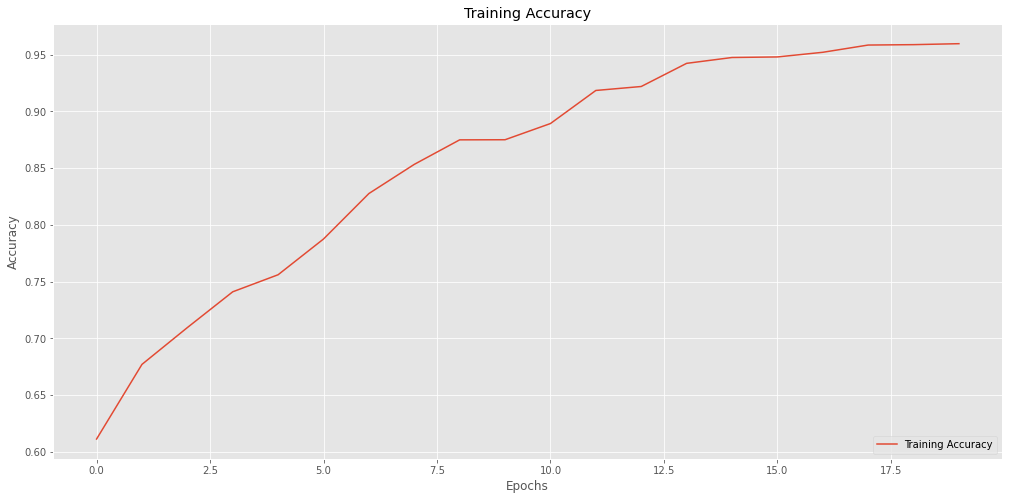

In [99]:
# Setting the type of plot style for the graph 
plt.style.use("ggplot") 

# Getting the accuracy and the validation accuracy 
accuracy = H.history["accuracy"]
validation_accuracy = H.history["val_accuracy"]

# Getting the loss and the validation loss 
loss = H.history["loss"]
validation_loss = H.history["val_loss"] 

# Getting the epochs range 
epochs_range = range(epochs) 

# Plotting the first graph for accuracy 
plt.figure(figsize=(17, 8)); 
plt.plot(epochs_range, accuracy, label = "Training Accuracy");  
plt.xlabel("Epochs"); 
plt.ylabel("Accuracy"); 
plt.legend(loc="lower right"); 
plt.title("Training Accuracy"); 
plt.show(); 

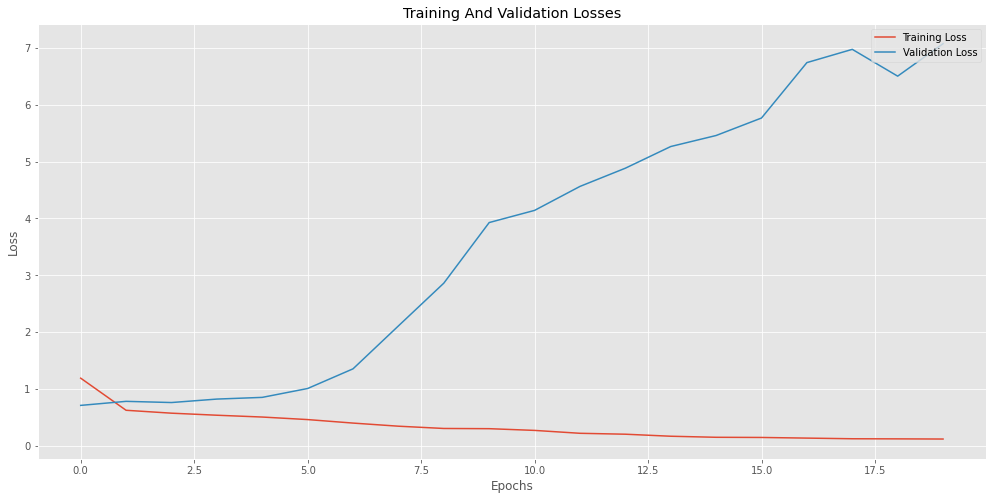

In [100]:
plt.figure(figsize=(17, 8)) 
plt.plot(epochs_range, loss, label = "Training Loss"); 
plt.plot(epochs_range, validation_loss, label = "Validation Loss"); 
plt.xlabel("Epochs"); 
plt.ylabel("Loss"); 
plt.legend(loc="upper right"); 
plt.title("Training And Validation Losses"); 
plt.show() 

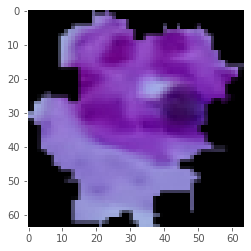

In [111]:
img = cv2.imread('/content/output/val/Parasitized/C101P62ThinF_IMG_20150918_151239_cell_84.png')
dim = (64,64); 
img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA); 
plt.grid(False) 
plt.imshow(img) 
plt.show() 

In [112]:
image = np.expand_dims(img, axis = 0); 
result = model.predict(image)
for key, value in (train_data_gen.class_indices.items()): 
    if value == result: 
        print("The Predicted Class is: {}".format(key))

The Predicted Class is: Parasitized
